[ryonkht/github/Chap.10/Chapter10.ipynb](https://raw.githubusercontent.com/ryonkht/github/master/Chap.10/Chapter10.ipynb) を改変

# 第10章 階層ベイズモデル：GLMMのベイズモデル化
## 10.1 例題：個体差と生存種子数（個体差あり）

In [1]:
date()

[1] "Tue Dec 27 12:55:39 2016"

In [2]:
sapply(c("pipeR", "dplyr", "tidyr", "ggplot2", "readr"), require, character.only = TRUE)

Loading required package: pipeR
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: ggplot2
Loading required package: readr


pipeR   dplyr   tidyr ggplot2   readr 
   TRUE    TRUE    TRUE    TRUE    TRUE

In [3]:
d <- read_csv("data/chap10/data7a.csv")

Parsed with column specification:
cols(
  id = col_integer(),
  y = col_integer()
)


In [4]:
str(d)
summary(d)

Classes 'tbl_df', 'tbl' and 'data.frame':	100 obs. of  2 variables:
 $ id: int  1 2 3 4 5 6 7 8 9 10 ...
 $ y : int  0 2 7 8 1 7 8 8 1 1 ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 2
  .. ..$ id: list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ y : list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


       id               y       
 Min.   :  1.00   Min.   :0.00  
 1st Qu.: 25.75   1st Qu.:1.00  
 Median : 50.50   Median :4.00  
 Mean   : 50.50   Mean   :4.03  
 3rd Qu.: 75.25   3rd Qu.:7.00  
 Max.   :100.00   Max.   :8.00  

In [5]:
options(repr.plot.width=4, repr.plot.height=4)

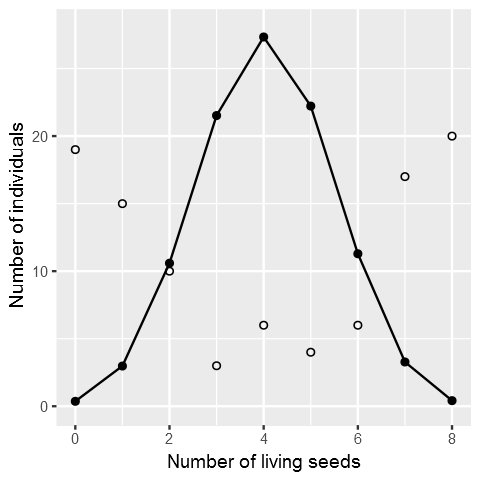

In [6]:
#fig. 10.1(B)
d %>>%
    {ggplot(data = (.), aes(x = y)) + 
    stat_count(geom = "point", shape = 21) + 
    stat_function(geom="point", n=9, fun = function(x, size, prob){dbinom(x, size = size, prob = prob) * nrow(.)}, 
                  args = list(size = 8, prob = 0.504)) + 
    stat_function(geom="line", n=9, fun = function(x, size, prob){dbinom(x, size = size, prob = prob) * nrow(.)}, 
                  args = list(size = 8, prob = 0.504)) + 
    xlab("Number of living seeds") + ylab("Number of individuals") + ylim(c(0, 28))}

実データの分散は `9.93` だが，最尤推定値 `0.504` だと2項分布の分散は  `1.99` となり，過分散

> [8章参照](https://whatalnk.github.io/stat-model-intro/Chap08)

In [7]:
d %>>% summarize_each(funs(mean, var), y)

mean,var
4.03,9.928384


最尤推定値は `0.504`

In [8]:
logL <- function(q, y){
    sum(y * log(q) + (8 - y) * log(1 - q) + log(choose(8, y)))
}

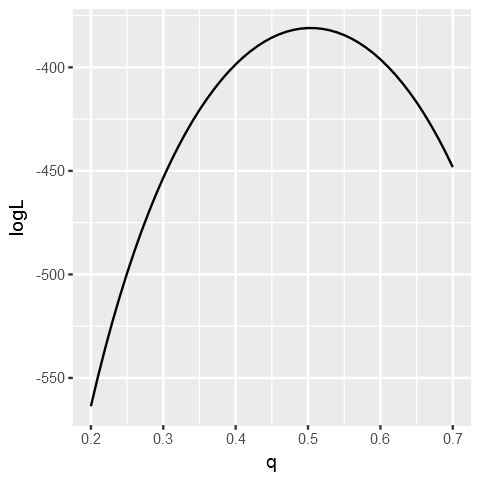

In [9]:
data_frame(q = seq(0.2, 0.7, 0.01)) %>>% 
    mutate(logL = sapply(q, function(x){logL(x, d$y)})) %>>% 
    ggplot(aes(x = q, y = logL)) + 
    geom_line()

（対数尤度関数を微分）

In [10]:
sum(d$y) / (8 * 100)

[1] 0.50375

二項分布の分散: `np(1 - p)`

In [11]:
8 * 0.504 * (1 - 0.504)

[1] 1.999872

## 10.2 GLMMの階層ベイズモデル化


第７章と同じように、リンク関数と線形予測子を

$$\text{logit}(q_i)=\beta+r_i$$

とする。

* $\beta$: 全個体共通のパラメーター
* $r_i$: 個体差（平均$0$、標準偏差$s$の正規分布にしたがうと仮定

データが得られる確率$p(\boldsymbol{Y}\mid\beta,\{r_i\})$は全100個体の二項分布の積なので、

$$p(\boldsymbol{Y}\mid\beta,\{r_i\})=\prod_{i} \binom{8}{y_i} {q_i}^{y_i}(1-q_i)^{8-y_i}$$

となる。推定したい事後分布は、

$$ \text{事後分布}\propto p(\boldsymbol{Y}\mid\beta,\{r_i\}) \times \text{事前分布} $$

となるので、あとは事前分布を指定すれば統計モデルの設計は完了。

線形予測子の切片$\beta$は正負どのような値をとってもよい実数

* 無情報事前分布（平均0、標準偏差100のすごくひらべったい正規分布）

$$p(\beta)=\frac{1}{\sqrt{2\pi \times 100^2}}\exp\left(
\frac{-\beta^2}{2\times 100^2}
\right)
$$

***
個体差$r_i$のパラメーターの事前分布はどうすればよいか

* 平均 $0$、標準偏差$s$</font>の正規分布と仮定

$$p(r_i\mid s)=\frac{1}{\sqrt{2\pi s^2}}\exp\left(
\frac{-r_i^2}{2s^2}
\right)
$$

個体差のばらつき$s$

* 確率分布である$s$の事後分布を推定
* 事後分布の推定には、事前分布が必要
* $s$については正の値であれば何でもかまわないので、事前分布$p(s)$を無情報事前分布とする

$$p(s)= \text{(0から$10^4$までの連続一様分布)}$$

* $p(r_i\mid s)$は階層事前分布
* 事前分布$p(r_i\mid s)$のパラメーター$s$は超パラメーター
* 事前分布の事前分布である$p(s)$は超事前分布 => 階層ベイズモデル

## 10.3 階層ベイズモデルの推定・予測

ベイズモデルでは「推定したいパラメーター」はことごとく事前分布とデータにもとづいて事後分布が推定される。

つまり、この例題の階層ベイズモデルの事後分布は、

$$p(\beta,s,\{r_i\} \mid \boldsymbol{Y})\propto p(\boldsymbol{Y}\mid\beta,\{r_i\}) p(\beta) p(s) \prod_{i}p(r_i\mid s)$$

### 10.3.1 階層ベイズモデルのMCMCサンプリング

WinBUGSを使って事後分布$p(\beta,s,\{r_i\}\mid\boldsymbol{Y})$からMCMCサンプリングする。


In [12]:
readLines("chap10-model.jags") %>>% cat(sep = "\n")

model
{
	for (i in 1:N) {
		Y[i] ~ dbin(q[i], 8) # binomial distribution
		logit(q[i]) <- beta + r[i] # probability of living
	}
	beta ~ dnorm(0, 1.0E-4) # non-informative prior distribution
	for (i in 1:N) {
		r[i] ~ dnorm(0, tau) # hierarchical prior distribution
	}
	tau <- 1 / (s * s)	 # tau is inverse of variance
	s ~ dunif(0, 1.0E+4) # non-informative prior distribution
}



### 10.3.2 階層ベイズモデルの事後分布推定と予測

生存種子数$y$の確率分布は、二項分布$p(y\mid \beta ,r)$と正規分布$p(r\mid s)$の**無限混合分布**

$$p(y\mid \beta ,s)=\int_{-\infty}^\infty p(y\mid\beta,r)p(r\mid s) dr$$


In [13]:
data.list <- list(
    N = nrow(d), 
    Y = d$y
)

In [14]:
inits.list <- list(
    beta = 0, 
    r = rnorm(nrow(d), 0, 0.1), 
    s = 1
)

In [15]:
library(rjags)

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


In [16]:
m <- jags.model(
    file = "chap10-model.jags",
    data = data.list,
    inits = list(inits.list, inits.list, inits.list),
    n.chain = 3
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 102
   Total graph size: 610

Initializing model



In [20]:
update(m, 100)

In [21]:
post.jags <- coda.samples(
    m, 
    c("beta", "r", "s"), 
    thin = 10, 
    n.iter = 10000
)

In [22]:
saveRDS(post.jags, file = "chap10-post-jags.rds")

In [17]:
post.jags <- readRDS(file = "chap10-post-jags.rds")

In [18]:
summary(post.jags)


Iterations = 1110:11100
Thinning interval = 10 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
beta    0.04950 0.3306 0.006036       0.011032
r[1]   -3.87482 1.7795 0.032490       0.034623
r[2]   -1.19119 0.8916 0.016278       0.017691
r[3]    2.00703 1.1023 0.020126       0.021560
r[4]    3.80044 1.7621 0.032171       0.032175
r[5]   -2.09304 1.0900 0.019901       0.020619
r[6]    1.97184 1.1029 0.020136       0.020870
r[7]    3.79481 1.7544 0.032030       0.035277
r[8]    3.84799 1.7980 0.032827       0.032394
r[9]   -2.08111 1.1031 0.020140       0.021116
r[10]  -2.08289 1.1038 0.020153       0.020814
r[11]  -0.05847 0.7863 0.014356       0.016347
r[12]  -3.84432 1.7470 0.031896       0.032385
r[13]  -2.06389 1.0960 0.020010       0.020623
r[14]  -0.03279 0.7973 0.014557       0.016410
r[15]   1.97768 1.1093 0.020253       0.022133
r[

In [19]:
str(post.jags)

List of 3
 $ : mcmc [1:1000, 1:102] -0.0248 0.00255 -0.31015 -0.49915 -0.24287 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:102] "beta" "r[1]" "r[2]" "r[3]" ...
  ..- attr(*, "mcpar")= num [1:3] 1110 11100 10
 $ : mcmc [1:1000, 1:102] 0.599 0.413 0.564 0.223 0.144 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:102] "beta" "r[1]" "r[2]" "r[3]" ...
  ..- attr(*, "mcpar")= num [1:3] 1110 11100 10
 $ : mcmc [1:1000, 1:102] -0.0823 0.1882 -0.2136 0.4182 0.5126 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:102] "beta" "r[1]" "r[2]" "r[3]" ...
  ..- attr(*, "mcpar")= num [1:3] 1110 11100 10
 - attr(*, "class")= chr "mcmc.list"


In [26]:
class(post.jags)

[1] "mcmc.list"

In [28]:
varnames(post.jags)

[1] "beta"   "r[1]"   "r[2]"   "r[3]"   "r[4]"   "r[5]"   "r[6]"   "r[7]"  
  [9] "r[8]"   "r[9]"   "r[10]"  "r[11]"  "r[12]"  "r[13]"  "r[14]"  "r[15]" 
 [17] "r[16]"  "r[17]"  "r[18]"  "r[19]"  "r[20]"  "r[21]"  "r[22]"  "r[23]" 
 [25] "r[24]"  "r[25]"  "r[26]"  "r[27]"  "r[28]"  "r[29]"  "r[30]"  "r[31]" 
 [33] "r[32]"  "r[33]"  "r[34]"  "r[35]"  "r[36]"  "r[37]"  "r[38]"  "r[39]" 
 [41] "r[40]"  "r[41]"  "r[42]"  "r[43]"  "r[44]"  "r[45]"  "r[46]"  "r[47]" 
 [49] "r[48]"  "r[49]"  "r[50]"  "r[51]"  "r[52]"  "r[53]"  "r[54]"  "r[55]" 
 [57] "r[56]"  "r[57]"  "r[58]"  "r[59]"  "r[60]"  "r[61]"  "r[62]"  "r[63]" 
 [65] "r[64]"  "r[65]"  "r[66]"  "r[67]"  "r[68]"  "r[69]"  "r[70]"  "r[71]" 
 [73] "r[72]"  "r[73]"  "r[74]"  "r[75]"  "r[76]"  "r[77]"  "r[78]"  "r[79]" 
 [81] "r[80]"  "r[81]"  "r[82]"  "r[83]"  "r[84]"  "r[85]"  "r[86]"  "r[87]" 
 [89] "r[88]"  "r[89]"  "r[90]"  "r[91]"  "r[92]"  "r[93]"  "r[94]"  "r[95]" 
 [97] "r[96]"  "r[97]"  "r[98]"  "r[99]"  "r[100]" "s"

In [29]:
varnames(post.jags)

NULL

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6)

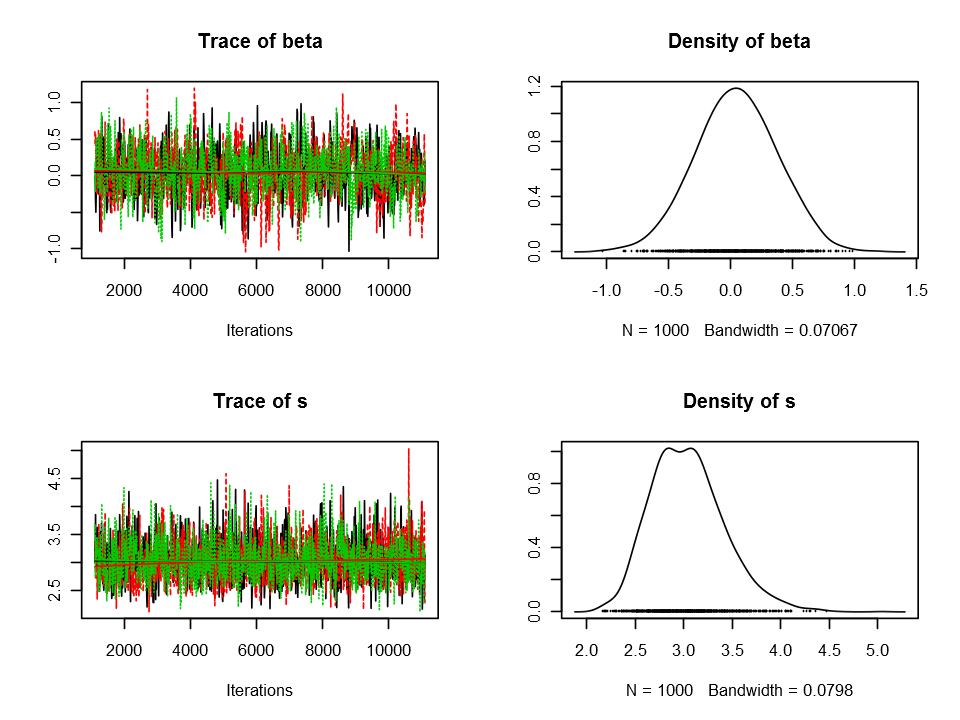

In [34]:
post.jags[,c("beta", "s"), drop=FALSE] %>>% plot()

In [37]:
options(repr.plot.width = 8, repr.plot.height = 9)

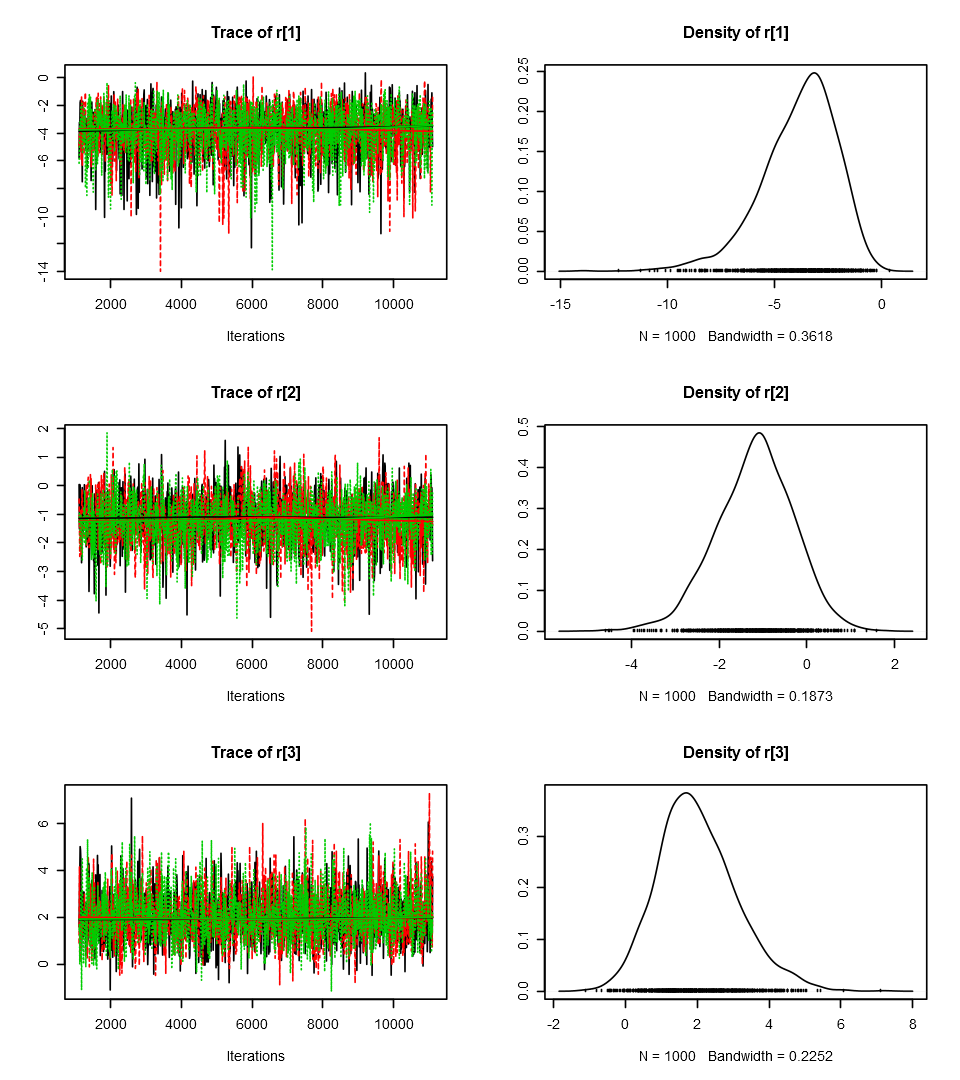

In [38]:
post.jags[,c("r[1]","r[2]","r[3]"), drop=FALSE] %>>% plot()

In [39]:
coda::gelman.diag(post.jags)

Potential scale reduction factors:

       Point est. Upper C.I.
beta        1.004       1.01
r[1]        1.000       1.00
r[2]        1.001       1.00
r[3]        1.001       1.00
r[4]        1.000       1.00
r[5]        1.004       1.01
r[6]        1.001       1.01
r[7]        1.001       1.00
r[8]        1.000       1.00
r[9]        1.002       1.01
r[10]       1.000       1.00
r[11]       1.000       1.00
r[12]       1.000       1.00
r[13]       1.003       1.01
r[14]       1.001       1.01
r[15]       1.002       1.01
r[16]       1.001       1.00
r[17]       1.001       1.00
r[18]       1.000       1.00
r[19]       1.002       1.00
r[20]       1.003       1.01
r[21]       1.001       1.00
r[22]       1.001       1.00
r[23]       1.000       1.00
r[24]       1.001       1.00
r[25]       0.999       1.00
r[26]       1.000       1.00
r[27]       0.999       1.00
r[28]       1.001       1.00
r[29]       1.000       1.00
r[30]       1.000       1.00
r[31]       1.001       1.01
r[32]  

推定された事後分布をくみあわせて、生存種子数ごとの個体数の分布を予測

In [33]:
varnames(post.jags)

[1] "beta"   "r[1]"   "r[2]"   "r[3]"   "r[4]"   "r[5]"   "r[6]"   "r[7]"  
  [9] "r[8]"   "r[9]"   "r[10]"  "r[11]"  "r[12]"  "r[13]"  "r[14]"  "r[15]" 
 [17] "r[16]"  "r[17]"  "r[18]"  "r[19]"  "r[20]"  "r[21]"  "r[22]"  "r[23]" 
 [25] "r[24]"  "r[25]"  "r[26]"  "r[27]"  "r[28]"  "r[29]"  "r[30]"  "r[31]" 
 [33] "r[32]"  "r[33]"  "r[34]"  "r[35]"  "r[36]"  "r[37]"  "r[38]"  "r[39]" 
 [41] "r[40]"  "r[41]"  "r[42]"  "r[43]"  "r[44]"  "r[45]"  "r[46]"  "r[47]" 
 [49] "r[48]"  "r[49]"  "r[50]"  "r[51]"  "r[52]"  "r[53]"  "r[54]"  "r[55]" 
 [57] "r[56]"  "r[57]"  "r[58]"  "r[59]"  "r[60]"  "r[61]"  "r[62]"  "r[63]" 
 [65] "r[64]"  "r[65]"  "r[66]"  "r[67]"  "r[68]"  "r[69]"  "r[70]"  "r[71]" 
 [73] "r[72]"  "r[73]"  "r[74]"  "r[75]"  "r[76]"  "r[77]"  "r[78]"  "r[79]" 
 [81] "r[80]"  "r[81]"  "r[82]"  "r[83]"  "r[84]"  "r[85]"  "r[86]"  "r[87]" 
 [89] "r[88]"  "r[89]"  "r[90]"  "r[91]"  "r[92]"  "r[93]"  "r[94]"  "r[95]" 
 [97] "r[96]"  "r[97]"  "r[98]"  "r[99]"  "r[100]" "s"

In [34]:
paste0("r[", c(1:100), "]")

[1] "r[1]"   "r[2]"   "r[3]"   "r[4]"   "r[5]"   "r[6]"   "r[7]"   "r[8]"  
  [9] "r[9]"   "r[10]"  "r[11]"  "r[12]"  "r[13]"  "r[14]"  "r[15]"  "r[16]" 
 [17] "r[17]"  "r[18]"  "r[19]"  "r[20]"  "r[21]"  "r[22]"  "r[23]"  "r[24]" 
 [25] "r[25]"  "r[26]"  "r[27]"  "r[28]"  "r[29]"  "r[30]"  "r[31]"  "r[32]" 
 [33] "r[33]"  "r[34]"  "r[35]"  "r[36]"  "r[37]"  "r[38]"  "r[39]"  "r[40]" 
 [41] "r[41]"  "r[42]"  "r[43]"  "r[44]"  "r[45]"  "r[46]"  "r[47]"  "r[48]" 
 [49] "r[49]"  "r[50]"  "r[51]"  "r[52]"  "r[53]"  "r[54]"  "r[55]"  "r[56]" 
 [57] "r[57]"  "r[58]"  "r[59]"  "r[60]"  "r[61]"  "r[62]"  "r[63]"  "r[64]" 
 [65] "r[65]"  "r[66]"  "r[67]"  "r[68]"  "r[69]"  "r[70]"  "r[71]"  "r[72]" 
 [73] "r[73]"  "r[74]"  "r[75]"  "r[76]"  "r[77]"  "r[78]"  "r[79]"  "r[80]" 
 [81] "r[81]"  "r[82]"  "r[83]"  "r[84]"  "r[85]"  "r[86]"  "r[87]"  "r[88]" 
 [89] "r[89]"  "r[90]"  "r[91]"  "r[92]"  "r[93]"  "r[94]"  "r[95]"  "r[96]" 
 [97] "r[97]"  "r[98]"  "r[99]"  "r[100]"

In [37]:
summary(post.jags)$quantiles[paste0("r[", c(1:100), "]"), "50%"]

r[1]        r[2]        r[3]        r[4]        r[5]        r[6] 
-3.64079944 -1.14331906  1.89483429  3.56498387 -1.98720336  1.87815059 
       r[7]        r[8]        r[9]       r[10]       r[11]       r[12] 
 3.57432164  3.57371455 -2.00347083 -1.99618935 -0.03221512 -3.58132518 
      r[13]       r[14]       r[15]       r[16]       r[17]       r[18] 
-1.98599619 -0.03175172  1.87023180  3.58205389  1.91011852 -3.61333292 
      r[19]       r[20]       r[21]       r[22]       r[23]       r[24] 
-1.16391191 -1.16414531 -1.96999175 -1.97744082  0.46058211  1.93862591 
      r[25]       r[26]       r[27]       r[28]       r[29]       r[30] 
 3.53981844 -0.59241508  3.55725014 -0.03853282  1.08138666 -3.63735964 
      r[31]       r[32]       r[33]       r[34]       r[35]       r[36] 
 3.59912519  1.86444736  3.53938121 -3.58803542 -1.17212070  1.08760141 
      r[37]       r[38]       r[39]       r[40]       r[41]       r[42] 
 1.92922540  3.51596406 -1.17956849 -1.98319598 -2.01554737 -3.58510495 
      r[43]       r[44]       r[45]       r[46]       r[47]       r[48] 
-3.66340573  1.89067530  3.63023161  0.48634138  1.84186707 -1.15007402 
      r[49]       r[50]       r[51]       r[52]       r[53]       r[54] 
 3.55560449 -1.97087100  0.47006847  1.91596120 -0.56000762  3.63708534 
      r[55]       r[56]       r[57]       r[58]       r[59]       r[60] 
-3.61981231  3.50369915  1.08040162 -0.61805213 -1.14739207 -3.60688925 
      r[61]       r[62]       r[63]       r[64]       r[65]       r[66] 
-3.61273709 -1.96904675 -1.17799157  3.53990957  1.91318592  1.86806169 
      r[67]       r[68]       r[69]       r[70]       r[71]       r[72] 
 1.90766772  3.51161053 -3.64401832 -3.56176652 -3.61234129  0.44154895 
      r[73]       r[74]       r[75]       r[76]       r[77]       r[78] 
-2.03016070 -3.63462539 -3.66046112 -3.63452792  3.53731948 -1.98366091 
      r[79]       r[80]       r[81]       r[82]       r[83]       r[84] 
 3.51577959 -0.07661939  1.91927379 -1.16737371 -2.01553840 -0.05472714 
      r[85]       r[86]       r[87]       r[88]       r[89]       r[90] 
 1.87896798 -3.63040686  3.50564829 -1.97173877  3.58617107  1.88628492 
      r[91]       r[92]       r[93]       r[94]       r[95]       r[96] 
 1.04838505 -1.16979118  3.58964021  1.04838129  1.11600563 -2.00958575 
      r[97]       r[98]       r[99]      r[100] 
-3.64887064 -0.01992541  1.84178501 -3.62460355

In [48]:
summary(post.jags)$quantiles["beta", "50%"] %>>% class()

[1] "numeric"

In [67]:
logistic <- function(beta, r){1 / (1 + exp(-(beta + r)))}
# r についての積分

integrand <- function(r, x, size, beta, s){
    dbinom(x, size = size, prob = logistic(beta, r)) * dnorm(r, mean = 0, sd = s)
}
# 各種子数について -Inf--Infまで積分
living_seed <- function(x, size, beta, s){
    sapply(x, function(xx){
        integrate(f = integrand, lower = -Inf, upper = Inf, 
                  x = xx, size = size, beta = beta, s = s
        )$value
    })
}
living_seed(x = 0:8, size = 8, beta = summary(post.jags)$quantiles["beta", "50%"], s = summary(post.jags)$quantiles["s", "50%"])

[1] 0.21216163 0.10557658 0.07733938 0.06683016 0.06407354 0.06720641 0.07827867
[8] 0.10783028 0.22070336

In [110]:
library(purrr)


Attaching package: 'purrr'

The following objects are masked from 'package:dplyr':

    contains, order_by



各回のMCMCサンプルの `beta` と `s` から 生存確率 `q` を生成して，その確率に従って `y`を生成．
各回の頻度分布を得る．

そこから 生存個数ごとに `quantile()`
* `0.025` -- `0.975`: 95%信用区間
* `0.25` -- `0.75`: 50%信用区間

In [174]:
post.jags[, c("beta", "s")] %>>% 
    purrr::map_df(function(x){as_data_frame(x)}) %>>% 
    {purrr::map2((.)$beta, (.)$s, function(x, y){
        living_seed(x = 0:8, size = 8, beta = x, s = y)})
    } %>>% 
    purrr::map_df(function(x){
        xx <- sample(0:8, 100, replace = TRUE, prob = x) %>>% factor(levels = 0:8) %>>% summary()
        d <- data.frame(matrix(xx, nrow = 1))
        names(d) <- c(0:8)
        d
    }) %>>% 
    purrr::dmap(quantile, probs = c(0.025, 0.975, 0.25, 0.75)) -> post.jags.quantiles
post.jags.quantiles

0,1,2,3,4,5,6,7,8
11,5,3.00,2,2,2,3,5,12
33,17,14.00,12,12,13,14,17,34
17,8,6.00,5,5,5,6,8,18
25,12,9.25,8,8,9,10,13,26


In [147]:
post.jags.quantiles[1, ] %>>% as.numeric() %>>% str()

 num [1:9] 0.1456 0.0874 0.0621 0.0526 0.05 ...


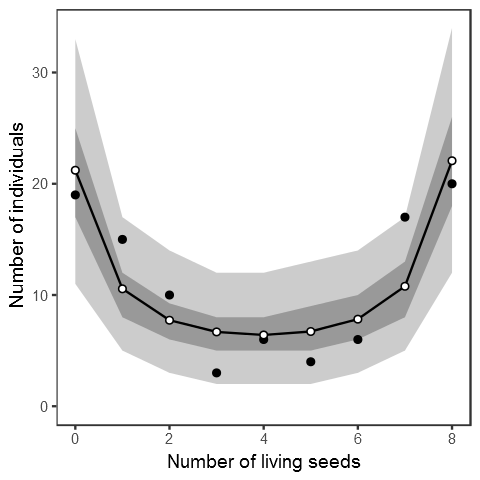

In [175]:
#fig. 10.4
ggplot() + 
    geom_ribbon(aes(x = c(0:8), ymin = as.numeric(post.jags.quantiles[1, ]), 
                        ymax = as.numeric(post.jags.quantiles[2, ])), fill = gray(0.8)) + 
    geom_ribbon(aes(x = c(0:8), ymin = as.numeric(post.jags.quantiles[3, ]), 
                        ymax = as.numeric(post.jags.quantiles[4, ])), fill = gray(0.6)) + 
        stat_count(data = d, mapping = aes(x = y), geom = "point", shape = 19) + 
        stat_function(data = data_frame(x = c(0:8)), mapping = aes(x), geom="line", n=9, 
                      fun = function(x, size, beta, s){living_seed(x, size, beta, s) * 100}, 
                      args = list(size = 8, 
                                  beta = summary(post.jags)$quantiles["beta", "50%"], 
                                  s = summary(post.jags)$quantiles["s", "50%"])) + 
        stat_function(data = data_frame(x = c(0:8)), mapping = aes(x), geom="point", n=9, 
                      fun = function(x, size, beta, s){living_seed(x, size, beta, s) * 100}, 
                      args = list(size = 8, 
                                  beta = summary(post.jags)$quantiles["beta", "50%"], 
                                  s = summary(post.jags)$quantiles["s", "50%"]), 
                      shape = 21, fill = "white") + 
    xlab("Number of living seeds") + ylab("Number of individuals") + 
#     ylim(c(0, 28)) + 
    theme_bw() + theme(panel.grid = element_blank())

* 薄いグレーは95%信用区間  
* 濃いグレーは50%信用区間

## 10.4 ベイズモデルで使うさまざまな事前分布

## 10.5 個体差＋場所差の階層ベイズモデル

* 植木鉢(pot)が10個($j\in \{\mathrm{A}, \mathrm{B}, \mathrm{C} \ldots , \mathrm{J} \}$)
* 各植木鉢に10個体の植物
* 個体番号 $i$ は $\{1, 2, \ldots , 100\}$（A は 1--10，Bは11--20）
* $j\in \{A, B, C, D, E\}$の植木鉢は無処理
* $j\in \{F, G, H, I, J\}$の植木鉢は施肥処理

In [176]:
d1 <- read_csv("data/chap10/d1.csv")
str(d1)

Parsed with column specification:
cols(
  id = col_integer(),
  pot = col_character(),
  f = col_character(),
  y = col_integer()
)


Classes 'tbl_df', 'tbl' and 'data.frame':	100 obs. of  4 variables:
 $ id : int  1 2 3 4 5 6 7 8 9 10 ...
 $ pot: chr  "A" "A" "A" "A" ...
 $ f  : chr  "C" "C" "C" "C" ...
 $ y  : int  6 3 19 5 0 19 4 8 12 8 ...
 - attr(*, "spec")=List of 2
  ..$ cols   :List of 4
  .. ..$ id : list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  .. ..$ pot: list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  .. ..$ f  : list()
  .. .. ..- attr(*, "class")= chr  "collector_character" "collector"
  .. ..$ y  : list()
  .. .. ..- attr(*, "class")= chr  "collector_integer" "collector"
  ..$ default: list()
  .. ..- attr(*, "class")= chr  "collector_guess" "collector"
  ..- attr(*, "class")= chr "col_spec"


In [199]:
{d1 %>>% group_by(f) %>>% summarize(mean(y))}[[2]]

[1] 6.64 4.40

fig. 10.7(A)

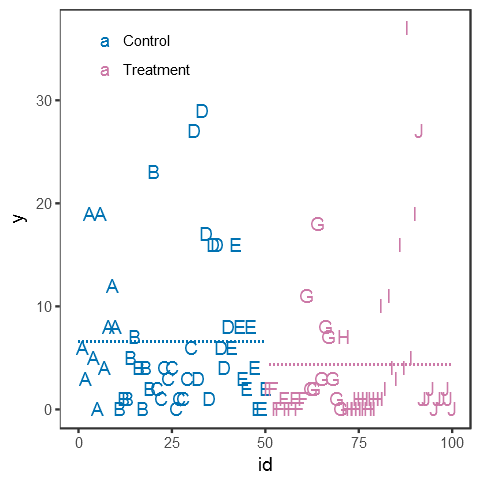

In [220]:
d1 %>>%
    ggplot(aes(x = id, y = y, label = pot, group = f, colour = f)) + geom_text() + 
        geom_segment(aes(x = 0, y = mean((.)$y[(.)$f == "C"]), 
                         xend = 50, yend = mean((.)$y[(.)$f == "C"])), 
                     colour = "#0072B2", linetype = "dotted") + 
        geom_segment(aes(x = 51, y = mean((.)$y[(.)$f == "T"]), 
                         xend = 100, yend = mean((.)$y[(.)$f == "T"])), 
                     colour = "#CC79A7", linetype = "dotted") + 
        theme_bw() +     
        theme(
            legend.title = element_blank(),
            legend.background = element_blank(), 
            legend.position = c(.2, .9), 
            panel.grid = element_blank()
        ) +
        scale_colour_manual(labels = c("Control", "Treatment"), values = c("#0072B2", "#CC79A7"))

fig. 10.7(B)

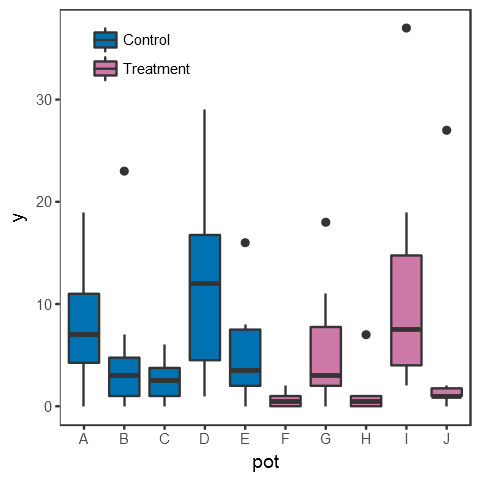

In [224]:
d1 %>>% ggplot(aes(x = pot, y = y, fill = f)) + geom_boxplot() + 
    theme_bw() + 
    theme(
        legend.title = element_blank(),
        legend.background = element_blank(), 
        legend.position = c(.2, .9), 
        panel.grid = element_blank()
    ) +
    scale_fill_manual(labels = c("Control", "Treatment"), values = c("#0072B2", "#CC79A7"))

ポアソン分布で考えると過分散

過分散の原因は**個体差**だけでなく**植木鉢の差**にもありそう

個体も植木鉢もどちらも反復ではなく<font color="Red">疑似反復</font>なので、**個体差**と**植木鉢差**を同時にあつかう統計モデルが必要

個体$i$の種子数$y_i$のばらつきを平均$\lambda_i$のポアソン分布で表現する。

$$p(y_i\mid \lambda_i)=\frac{{\lambda_i}^{y_i}\exp (-\lambda_i)}{y_i!}$$

線形予測子と対数リンク関数を使って平均種子数$\lambda_i$は、

$$\log \lambda_i=\beta_1+\beta_2f_i+r_i+r_{j(i)}$$


> $\beta_1: 切片$  
> $f_i:$ 施肥処理の有無をあらわす因子型の説明変数  
> $\beta_2: f_i$の係数  
> $r_i: 個体i$の効果  
>$r_{j(i)}: 植木鉢j$の効果

$r_i$は100個、$r_{j(i)}$は10個あり、それぞれのばらつきを$s、s_p$とする。

パラメーターの事前分布

+ **大域的**な平均パラメーターである$\beta_1$と$\beta_2$は<font color="Red">無情報事前分布</font>、平均0の押しつぶされた正規分布

+ **大域的**なばらつきパラメーターである$s$と$s_p$は<font color="Red">無情報事前分布</font>、0から$10^4$の範囲をとる一様分布

+ **局所的**パラメーターである$r_i$と$r_{j(i)}$は<font color="Red">階層事前分布</font>、平均0、標準偏差はそれぞれ$s$と$s_p$

あとはWinBUGSなどを使って事後分布推定

In [225]:
readLines("chap10-model2.jags") %>>% cat(sep = "\n")

model
{
	for (i in 1:N.sample) {
		Y[i] ~ dpois(lambda[i])
		log(lambda[i]) <- beta1 + beta2 * F[i] + r[i] + rp[Pot[i]]
	}
	beta1 ~ dnorm(0, 1.0E-4)
	beta2 ~ dnorm(0, 1.0E-4)
	for (i in 1:N.sample) {
		r[i] ~ dnorm(0, tau[1])
	}
	for (j in 1:N.pot) {
		rp[j] ~ dnorm(0, tau[2])
	}
	for (k in 1:N.tau) {
		tau[k] <- 1.0 / (s[k] * s[k])
		s[k] ~ dunif(0, 1.0E+4)
	}
}


### Rで実行

In [234]:
as.numeric(d1$f == "T")

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [249]:
data.list2 <- list(
    N.sample = nrow(d1), 
    N.pot = length(unique(d1$pot)), 
    N.tau = 2, 
    Y = d1$y, 
    F = as.numeric(d1$f == "T"), 
    Pot = as.numeric(as.factor(d1$pot))
)

In [251]:
inits.list2 <- list(
    beta1 = 0, 
    beta2 = 0, 
    s = c(1, 1), 
    r = rnorm(data.list2[["N.sample"]], 0, 0.1), 
    rp = rnorm(data.list2[["N.pot"]], 0, 0.1)
)

In [252]:
m2 <- jags.model(
    file = "chap10-model2.jags", 
    data = data.list2, 
    inits = list(inits.list2, inits.list2, inits.list2), 
    n.chain = 3
)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 114
   Total graph size: 743

Initializing model



In [253]:
update(m2, 1000)

In [257]:
post.jags2 <- coda.samples(
    m2,
    c("beta1", "beta2",  "s", "r", "rp"), 
    thin = 50, n.iter = 50000
)

In [258]:
saveRDS(post.jags2, file = "chap10-post-jags2.rds")

In [18]:
post.jags2 <- readRDS(file = "chap10-post-jags2.rds")

In [262]:
summary(post.jags2)


Iterations = 52050:102000
Thinning interval = 50 
Number of chains = 3 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean     SD Naive SE Time-series SE
beta1   1.306468 0.5351 0.009770       0.029062
beta2  -0.782639 0.7591 0.013860       0.038330
r[1]   -0.050305 0.4988 0.009106       0.009781
r[2]   -0.611666 0.5557 0.010146       0.010149
r[3]    1.092708 0.3914 0.007147       0.007681
r[4]   -0.185131 0.4890 0.008928       0.009088
r[5]   -1.585058 0.7056 0.012883       0.012811
r[6]    1.083354 0.3928 0.007171       0.007414
r[7]   -0.384724 0.5176 0.009449       0.009572
r[8]    0.223355 0.4532 0.008275       0.008440
r[9]    0.617843 0.4291 0.007835       0.008047
r[10]   0.219331 0.4608 0.008414       0.008536
r[11]  -1.143528 0.7443 0.013590       0.013509
r[12]  -0.687210 0.6616 0.012078       0.012082
r[13]  -0.707063 0.6843 0.012494       0.012255
r[14]   0.411433 0.5290 0.00965

$\beta_2$ の（周辺）事後分布の95%区間は -2.23 -- 0.86

* 施肥効果なさそう

In [263]:
gelman.diag(post.jags2)

Potential scale reduction factors:

       Point est. Upper C.I.
beta1           1       1.00
beta2           1       1.00
r[1]            1       1.00
r[2]            1       1.00
r[3]            1       1.01
r[4]            1       1.00
r[5]            1       1.00
r[6]            1       1.00
r[7]            1       1.00
r[8]            1       1.00
r[9]            1       1.02
r[10]           1       1.01
r[11]           1       1.00
r[12]           1       1.00
r[13]           1       1.00
r[14]           1       1.00
r[15]           1       1.00
r[16]           1       1.00
r[17]           1       1.00
r[18]           1       1.00
r[19]           1       1.00
r[20]           1       1.00
r[21]           1       1.00
r[22]           1       1.00
r[23]           1       1.00
r[24]           1       1.00
r[25]           1       1.00
r[26]           1       1.00
r[27]           1       1.00
r[28]           1       1.00
r[29]           1       1.00
r[30]           1       1.00
r[31]  

In [259]:
options(repr.plot.width = 8, repr.plot.height = 6)

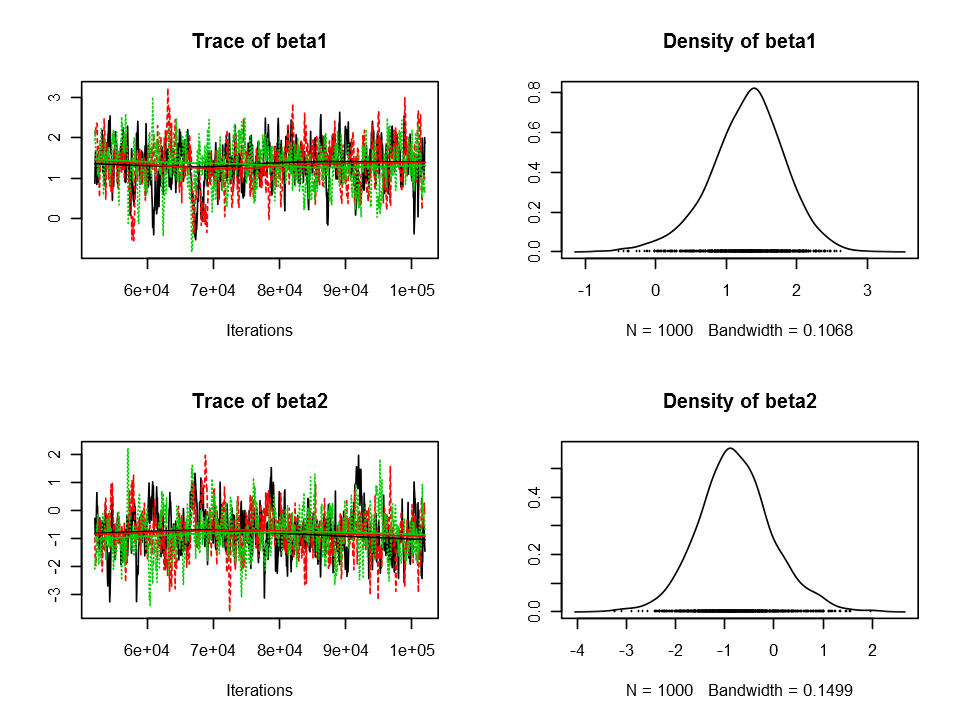

In [261]:
post.jags2[,c("beta1", "beta2"), drop=FALSE] %>>% plot()

In [264]:
options(repr.plot.width = 4, repr.plot.height = 4)

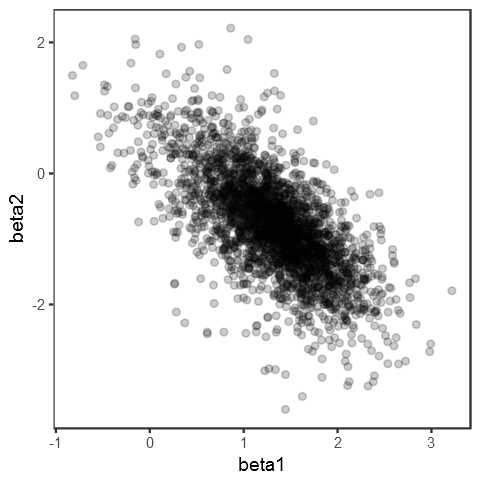

In [270]:
post.jags2[,c("beta1", "beta2")] %>>% 
    purrr::map_df(function(x){as_data_frame(x)}) %>>% 
    ggplot(aes(x = beta1, y = beta2)) + geom_point(alpha = 0.2) + theme_bw() + theme(panel.grid = element_blank())

## 10.6 この章のまとめと参考文献
+ GLMMをベイズモデル化すると**階層ベイズモデル**になる
+ 階層ベイズモデルとは、事前分布となる確率分布のパラメーターにも事前分布が指定されている統計モデルである
+ 無情報事前分布と階層事前分布を使うことで、ベイズ統計モデルから主観的な事前分布を排除できる
+ **個体差＋場所差**といった複雑な構造のあるデータの統計モデリングでは、階層ベイズモデルとMCMCサンプリングによるパラメーター推定の組み合わせで対処するのが良い

統計モデルと推定方法の区別に注意  
統計モデルは<font color="Red">階層ベイズモデル</font>、推定方法は<font color="Red">MCMCサンプリング</font>

In [271]:
devtools::session_info()

Session info -------------------------------------------------------------------
Packages -----------------------------------------------------------------------


 setting  value                       
 version  R version 3.3.2 (2016-10-31)
 system   x86_64, mingw32             
 ui       RTerm                       
 language (EN)                        
 collate  Japanese_Japan.932          
 tz       Asia/Tokyo                  
 date     2016-12-27                  

 package    * version date       source                            
 assertthat   0.1     2013-12-06 CRAN (R 3.2.1)                    
 Cairo        1.5-9   2015-09-26 CRAN (R 3.2.2)                    
 coda       * 0.18-1  2015-10-16 CRAN (R 3.2.3)                    
 colorspace   1.2-7   2016-10-11 CRAN (R 3.3.2)                    
 crayon       1.3.2   2016-06-28 CRAN (R 3.3.1)                    
 DBI          0.5-1   2016-09-10 CRAN (R 3.2.5)                    
 devtools     1.12.0  2016-06-24 CRAN (R 3.3.1)                    
 digest       0.6.10  2016-08-02 CRAN (R 3.3.1)                    
 dplyr      * 0.5.0   2016-06-24 CRAN (R 3.2.5)                    
 evalua